In [1]:
import ujson
import numpy 
import datetime

In [2]:
summaries = {}
ctr = 0
for line in open('user_project_summaries.json'): # lazy iteration because the file is large
#     if ctr == 20: 
#         break
    print ctr,
    ctr+=1
    summaries.update(ujson.loads(line))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46


In [3]:
from features import *
import features
reload(features)
import sys, os
sys.path.append(os.getcwd())

In [4]:
'''We are using all the data from the user from whom we we have previously 
classfied what their primary langauge is '''

isocodes = ujson.load(open('isocodes.json'))  # mapping from  iso code to language name
user_langs = ujson.load(open('user_inferredlangs.json'))  # mapping from userid to inferred language
#remove Latin because it's not a reliable inference
#TODO for later: get next-best language besides Latin in the inference function
# remove uncommon languages
lang_counts = {}
for user in user_langs:
    lang = user_langs[user]
    lang_counts[lang] = lang_counts.get(lang, 0) + 1
    ctr+=1
user_langs = {user: lang for user, lang in user_langs.items() if lang!='la' and lang_counts[lang]>=100 and user in summaries}
langset = sorted(list(set(user_langs.values())))
lang_num_map = {lang: i for i, lang in enumerate(langset)} #key is langauge isocode, value is number 
print 'lang data created with', len(user_langs), 'users and', len(langset), 'languages', langset

lang data created with 43862 users and 18 languages [u'ar', u'ca', u'de', u'el', u'en', u'es', u'fr', u'he', u'it', u'ja', u'ko', u'nl', u'pl', u'pt', u'ru', u'th', u'tr', u'zh']


In [5]:
# time utilities
def convert_time(el):
    """Human readable time"""
    el = int(str(el)[:10])
    return datetime.date.fromtimestamp(el)

def timediff(t1, t2):
    """difference between times (millisec precision) as days"""
    return (t1-t2)/(86400.*1000)

### Filter Tutorials

In [6]:
not_tutorials = {}

for i in range(10): 
    print i, 
    notT_list = ujson.load(open('tutorial_comparisons/nottutorials_' + str(i) +'.json'))
    for entry in notT_list: 
        if entry[0] not in summaries:
            continue
        proj_name = entry[1].split("_summary.json")[0]
        if entry[0] not in not_tutorials: 
            not_tutorials[entry[0]] = {}
        try: 
            not_tutorials[entry[0]][proj_name] = summaries[entry[0]][proj_name]
        except KeyError: 
            print entry[0], proj_name


0 1 2 3 4 5 6 7 8 9 00999 p005_006_Draw
00999 p002_002_WildLifeShow
00999 p010_010_RememberInformation
00999 p011_011_DetermineLocation
00999 p006_004_Draw2
00999 p012_012_ProcessAList
00999 p008_008_MoleMash


In [7]:
not_tutorials = {user: not_tutorials[user] for user in not_tutorials.keys() if len(not_tutorials[user])>0}
# SR's fix

# Featurizers

## Time featurizer

In [8]:
def projectLengthFeatures(projects):
    """moments of project lengths and intervals, as well as number of projects"""
    lengths = getProjectLengths(projects)
    intervals = getProjectIntervals(projects)
    
    #note: feature names are for our reference only
    userDict = {} 
    userDict["mean of lengths"] = numpy.mean(lengths)
    userDict["stddev of lengths"] = numpy.std(lengths)
    userDict["mean of intervals"] = numpy.mean(lengths)
    userDict["stddev of intervals"] = numpy.std(lengths)
    
    userDict["num projects"] = numProjects(projects)
    
    return userDict

In [9]:
def dayAnalysisFeatures(projects):
    """number of projects on each day of the week, and the percentage of them on a weekday"""
    byday = numOnDay(projects)

    userDict = {day: byday[i] for i, day in enumerate(["Monday", 
                                                       "Tuesday", 
                                                       "Wednesday", 
                                                       "Thursday", 
                                                       "Friday", 
                                                       "Saturday", 
                                                       "Sunday"])}
    return userDict

In [10]:
def decileProjects(projects):
    numbins = 10
    hist = projectsPerUserPeriod(projects, bins=numbins)
    
    userDict = {'decile '+str(i+1): hist[i] for i in range(numbins)}
    return userDict

## Code Features


In [11]:
def deltaDeciles(decileDict, name):
    values = sortDeciles(decileDict)
    deltas = {}
    for i in range(10): 
        if i== 0: pass
        else: deltas[str(i) + " " + name] = values[i]-values[i-1]
    return deltas


def sortDeciles(decileDict):
    deciles_sorted = []
    keys = decileDict.keys()
    for key in keys: 
        deciles_sorted.insert(int(key[-1]), decileDict[key])
    return deciles_sorted



In [12]:
def summaryOBlockDecile(projects): 
    hist = decileOrphanBlocks(projects)
    userDict = {'Orphan Decile '+str(i+1): hist[i] for i in range(10)}
    return userDict

In [13]:
def summaryDecileTLBlocks(projects): 
    hist = decileTypesTopLevelBlocks(projects)
    userDict = {'TopLevel Decile '+str(i+1): hist[i] for i in range(10)}
    return userDict

In [14]:
def summaryDecileNumScreens(projects): 
    hist = decileNumScreens(projects)
    userDict = {'NumScreens Decile '+str(i+1): hist[i] for i in range(10)}
    return userDict

In [15]:
def summaryDeltasTLBlocks(projects): 
    tlblocks = summaryDecileTLBlocks(projects)
    return deltaDeciles(tlblocks, "TL blocks delta")

In [16]:
def summaryDeltasOBlock(projects): 
    oblock = summaryOBlockDecile(projects)
    return deltaDeciles(oblock,"O blocks delta")

In [17]:
def summaryDeltasNumScreens(projects): 
    numscreens = summaryDecileNumScreens(projects)
    return deltaDeciles(numscreens, "numscreens blocks delta")

In [36]:
def summaryAverages(projects):
    userDict = {} 
    userDict["mean of numScreens"] = numpy.mean(getNumScreens(projects))
    userDict["NB"] = averageNumBlocks(projects)
    userDict["OB"] = getAverageOrphanBlocks(projects)
    
    userDict["TL"] = getAverageTypeTLBlocks(projects)
    userDict["TL2"] = getAverageNumTLBlocks(projects)
    
    userDict["NC"] = averageNumComponents(projects)
    userDict["NTC"] = averageNumTypeComponents(projects)

    userDict["MC"] = aveNumMediaAssets(projects)
    
    userDict["NP"] = averageNumProcedures(projects)
    userDict["NS"] = averageNumStrings(projects) 
    
    #userDict["KW"] = countKeywords(projects)
    
    varList = getAllVariables(projects)
    userDict["local vars"] = varList[0]
    userDict["global vars"] = varList[1]
    
    controls_dict = getControlsBlocks(projects)
    userDict['controls_if'] = controls_dict['controls_if']
    userDict['controls_forEach'] = controls_dict['controls_forEach']
    userDict['controls_choose'] = controls_dict['controls_choose']
    userDict['controls_while'] = controls_dict['controls_while']



    return userDict

In [87]:
def classesFeaturizers(projects): 
    userDict = {} 
    classes = getClasses(projects)
    cList = ['TableArrangement', 'DatePicker', 'Canvas', 
             'CheckBox', 'Web', 'Clock', 'BluetoothServer', 
             'ActivityStarter', 'Texting', 'Label', 'Spinner', 
             'Camera', 'BluetoothClient', 'PhoneCall', 'LocationSensor', 
             'VerticalArrangement', 'HorizontalArrangement', 'Sharing', 
             'TextToSpeech', 'GoogleMap', 'Slider', 'OrientationSensor', 
             'ListView', 'PhoneNumberPicker', 'TinyDB', 'NxtDirectCommands', 
             'Sound', 'ListPicker', 'SpeechRecognizer', 'Button', 'WebViewer',
             'BarcodeScanner', 'NxtDrive', 'Camcorder', 'Notifier', 'TextBox',
             'AccelerometerSensor', 'Image', 'VideoPlayer', 'TinyWebDB',
             'Player', 'File', 'YandexTranslate']
   
    for key in cList: 
        userDict[key] = classes[key]
        
    return userDict

In [91]:
j = 0
for user in userlabels:
    if user in not_tutorials: 
        j+=1
        if j % 1000 == 0: 
            print j,
        projects = getAllProjects(userID, True)
        classesFeaturizers(projects)
        

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000


In [21]:
def getControlsBlocks(projects):
    controls_dict = {'controls_if': 0, 'controls_forEach': 0 , 'controls_while': 0, 'controls_choose': 0}
    numScreens = getScreenNames(projects)
    i= 0
    while i < len(projects):
        for screenName in numScreens[i]:
            if screenName in projects[i] and 'Active Blocks' in projects[i][screenName] and 'Types' in projects[i][screenName]['Blocks']['Active Blocks']:
                allBlocks = projects[i][screenName]['Blocks']['Active Blocks']['Types']
                
                if 'controls_if' in allBlocks: 
                    controls_dict['controls_if'] += projects[i][screenName]['Blocks']['Active Blocks']['Types']['controls_if']
                if 'controls_forEach' in allBlocks: 
                    controls_dict['controls_forEach'] += projects[i][screenName]['Blocks']['Active Blocks']['Types']['controls_forEach']
                if 'controls_while' in allBlocks: 
                    controls_dict['controls_while'] += projects[i][screenName]['Blocks']['Active Blocks']['Types']['controls_while']
                if 'controls_choose' in allBlocks: 
                    controls_dict['controls_choose'] += projects[i][screenName]['Blocks']['Active Blocks']['Types']['controls_choose']
               
        i+=1
    final_dict = normalizeDict(controls_dict, projects)
    return final_dict

In [22]:
def normalizeDict(d, projects): 
    np = numProjects(projects)
    if float(np) == 0: np == 1
    for entry in d: 
        try: 
            d[entry] = d[entry] / float(np)
        except ZeroDivisionError: 
            print entry, np
    return d


In [92]:
def getClasses(projects):
    class_dict = {u'TableArrangement':0, u'DatePicker':0, u'Canvas':0,
                  u'CheckBox':0, u'Web':0, u'Clock':0, u'BluetoothServer':0, u'ActivityStarter':0,
                  u'Texting':0, u'Label':0, u'Spinner':0, u'Camera':0, u'BluetoothClient':0, 
                  u'PhoneCall':0, u'LocationSensor':0, u'VerticalArrangement':0,
                  u'HorizontalArrangement':0, u'Sharing':0, u'TextToSpeech':0,
                  u'GoogleMap' :0, u'Slider':0, u'OrientationSensor':0, u'ListView':0, 
                  u'PhoneNumberPicker':0, u'TinyDB':0, u'NxtDirectCommands':0, u'Sound':0,
                  u'ListPicker':0, u'SpeechRecognizer':0, u'Button':0, u'WebViewer':0, u'BarcodeScanner':0,
                  u'NxtDrive':0, u'Camcorder':0, u'Notifier':0, u'TextBox':0, u'AccelerometerSensor':0,
                  u'Image':0, u'VideoPlayer':0, u'TinyWebDB':0, u'Player':0, u'File':0, u'YandexTranslate':0}
    
    screenNames = getScreenNames(projects)
    i= 0
    while i < len(projects):
        for screenName in screenNames[i]:
            if screenName in projects[i] and 'Components' in projects[i][screenName] and 'Type and Frequency' in projects[i][screenName]['Components']:
                types = projects[i][screenName]['Components']['Type and Frequency']
                for entry in types: 
                    if entry in class_dict: 
                        class_dict[entry] += projects[i][screenName]['Components']['Type and Frequency'][entry]
        i+=1
    final_dict = normalizeDict(class_dict, projects)

    return final_dict

In [81]:
masterSet = set()
j = 0
for user in userlabels:
    if user in not_tutorials: 
        j+=1
        if j % 1000 == 0: 
            print j,
        projects = getAllProjects(userID, True)
        screenNames = getScreenNames(projects)
        while i < len(projects):
            for screenName in screenNames[i]:
                if screenName in projects[i] and 'Active Blocks' in projects[i][screenName] and 'Types' in projects[i][screenName]['Blocks']['Active Blocks']:
                    allBlocks = projects[i][screenName]['Blocks']['Active Blocks']['Types']
                    for c in allBlocks: 
                        if c.split("_")[0] not in masterSet: 
                            masterSet.add(c.split("_")[0])
            i+=1

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000


In [97]:
keys = not_tutorials['11542'].keys()
for key in keys: 
    blocks = not_tutorials['11542'][key]['Screen1']['Blocks']['Active Blocks']['Types']
    for block in blocks: 
        if 'math' in block:
            print block

math_compare
math_random_int
math_add
math_number
math_number
math_random_int
math_add
math_number
math_compare
math_abs
math_add
math_single
math_format_as_decimal
math_on_list
math_number


In [106]:
masterSet = set()
j = 0
for user in userlabels:
    if user in not_tutorials: 
        j+=1
        if j % 1000 == 0: 
            print j,
        projects = getAllProjects(userID, True)
        screenNames = getScreenNames(projects)
        while i < len(projects):
            for screenName in screenNames[i]:
                if screenName in projects[i] and 'Active Blocks' in projects[i][screenName]['Blocks'] and 'Types' in projects[i][screenName]['Blocks']['Active Blocks']:
                    allBlocks = projects[i][screenName]['Blocks']['Active Blocks']['Types']
                    #for block in allBlocks: 
                        #print block
            break
           # i+=1

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000


In [103]:
print masterSet

set([])


In [90]:
j = 0
math_
for user in userlabels:
    if user in not_tutorials: 
        j+=1
        if j % 1000 == 0: 
            print j,
        projects = getAllProjects(userID, True)
        for block in blocks: 
            if 'math' in block:
                print block
        

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000


### Setup

In [24]:
def combine_featfuncs(funclist):
    def combined(user):
        basedict = funclist[0](user)
        for f in funclist[1:]:
            basedict.update(f(user))
        return basedict
    return combined

In [31]:
def getAllProjects(userID, no_tutorials): 
    """list of projects sorted by creation times"""
    if (no_tutorials):
        try: 
            projectlist = not_tutorials[userID].values()
        except:
            print userID
    else: 
        projectlist = summaries[userID].values()
    return sorted(projectlist,
                  key=lambda project: project['**created']) 

def userDuration(projectlist):
    """get the duration (difference between last and earliest creation dates)"""
    return timediff(projectlist[-1]['**created'], projectlist[0]['**created'])


def getProjects(userID, no_tutorials):
    return getAllProjects(userID, no_tutorials)
     

In [27]:
langgroups = {'es': 'eur',
              'pt': 'eur', 
              'it': 'eur', 
              'de': 'eur', 
              'fr': 'eur', 
              'ca': 'eur', 
              'el': 'eur', 
              'nl': 'eur', 
              'pl': 'eur', 
              'ru': 'eur',
              'ko': 'asia', 
              'zh': 'asia', 
              'ja': 'asia', 
              'th': 'asia'}
langgroup_num_map = {'eur': 0, 'asia': 1}



In [28]:
def get_user_labels():
    return {user: lang_num_map[lang] for user, lang in user_langs.items()}

In [88]:
time_combined = combine_featfuncs([projectLengthFeatures, dayAnalysisFeatures,decileProjects])
code_combined = combine_featfuncs([summaryOBlockDecile,summaryDecileTLBlocks,summaryDecileNumScreens,summaryDeltasTLBlocks,summaryDeltasOBlock,summaryDeltasNumScreens, summaryAverages, classesFeaturizers])  

In [93]:
from sklearn.feature_extraction import DictVectorizer

all_features = []
time_features = [] 
code_features = []

userlabels = get_user_labels()

y = []
ctr = 0
for user in userlabels:
    if user in not_tutorials: 

        projects = getProjects(user, True)  # this returns projects sorted by creation date that include tutorials 

        y.append(userlabels[user])

        time_features.append(time_combined(projects))
        code_features.append(code_combined(projects))


        # merge time and code feature dicts
        all_features_user = time_features[-1].copy()
        all_features_user.update(code_features[-1])
        all_features.append(all_features_user)

        ctr+=1
        if ctr%1000==0:
            print ctr/1000,
        


y = numpy.array(y)

timevec = DictVectorizer()

Xtime = timevec.fit_transform(time_features) 

codevec = DictVectorizer()

Xcode = codevec.fit_transform(code_features)

allvec = DictVectorizer()

Xall = allvec.fit_transform(all_features)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43


In [94]:
from sklearn.preprocessing import scale
from numpy import *
# # convert to dense matrices since these are dense anyway
Xtime = scale(Xtime.toarray())
Xcode = scale(Xcode.toarray())
Xall = scale(Xall.toarray())

Chance is 0.478097765171
Building a logreg model with 22 time
Fold 1
Fold 2
Fold 3
Confusion matrix, without normalization


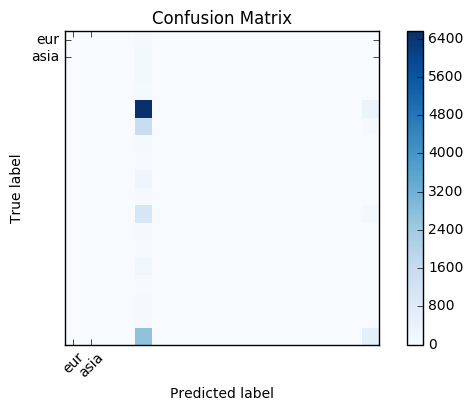

Average accuracy 0.491730616094
Building a logreg model with 116 code
Fold 1
Fold 2
Fold 3
Confusion matrix, without normalization


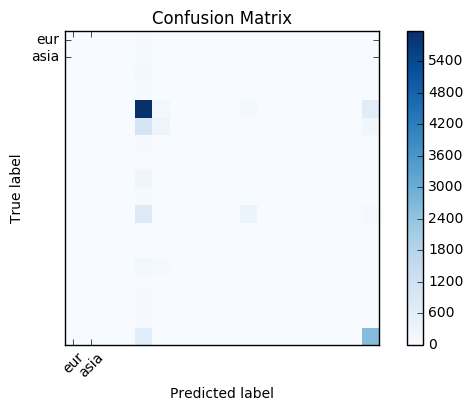

Average accuracy 0.631676581245
Building a logreg model with 138 all
Fold 1
Fold 2
Fold 3
Confusion matrix, without normalization


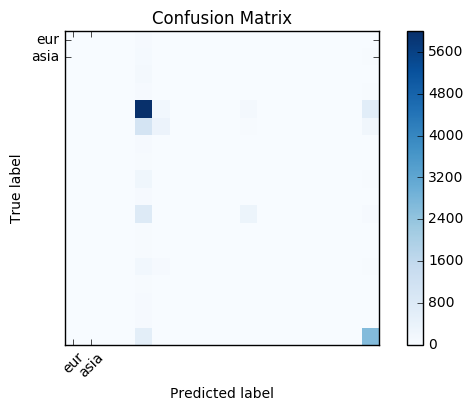

Average accuracy 0.641512151032


In [95]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from  sklearn.metrics import f1_score 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline 
from plotcnf import plot_confusion_matrix

print 'Chance is', max(numpy.bincount(y))/float(len(y))


foldindices = StratifiedKFold(y)

labels = map(lambda x:x[0], sorted(langgroup_num_map.items(), key=lambda x:x[1]))  
# languages corresponding to class labels as a list

    
k = 70 #num neighbors for kNN

classifiers = [('logreg', LogisticRegression())]  # no knn because it's too slow 
#multi_class='multinomial', 
                                                             

for modelname, model in classifiers:
    for featname, X in [('time', Xtime), ('code', Xcode), ('all', Xall)]:
        print  'Building a', modelname, 'model with', X.shape[1], featname
    
        cvaccs = numpy.zeros(len(foldindices))
        #cvf1 = numpy.zeros(len(foldindices))
        for i, (trainidx, testidx) in enumerate(foldindices):
            print 'Fold', i+1
        
            ytrain = y[trainidx]
            ytest = y[testidx]
        
            Xtrain = X[trainidx, :]  
            Xtest = X[testidx, :]
            
            model.fit(Xtrain, ytrain)
            cvaccs[i] = model.score(Xtest, ytest)
        
            predictions = model.predict(Xtest)
            #cvf1[i] = f1_score(ytest, predictions)
            
            #print '****', modelname, cvaccs[i]
        #analyze last fold only
        cnf_matrix = confusion_matrix(ytest, predictions)  
        plot_confusion_matrix(cnf_matrix, labels)
        plt.show()
        
        print 'Average accuracy', numpy.mean(cvaccs)